In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.autonotebook import tqdm
from polar import PolarCode,get_frozen
from reliability_sequence import Reliability_Sequence
from utils import errors_ber,errors_bler
import matplotlib.pyplot as plt
import random
import os

In [500]:
n = 5
N = 2**n 
K = 16
snr = 1
batch_size = 64
num_samples = 20000
seed = 42

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
torch.manual_seed(seed)
g = torch.Generator()
g.manual_seed(seed)

In [345]:

def create_data(num_samples, n, K, snr,rs):
    """
    Create a reproducible polar code dataset
    
    Parameters:
    - num_samples: Total number of samples to generate
    - batch_size: Batch size for data generation
    - n: Polar code parameter
    - K: Information bit length
    - snr: Signal-to-Noise Ratio
    - rs: Reliability Sequence

    Returns:
    - Saved .npz file with dataset
    """

    msg_bits_list = []
    bpsk_list = []
    codeword_list = []
    corrupted_codeword_list = []
    
    polar = PolarCode(n, K, rs = rs, use_cuda=False,hard_decision=True)
    # Loop to generate data samples
    for i in range(num_samples):
        msg_bits = (torch.rand(K) > 0.5).float()
        bpsk = 1 - 2 * msg_bits

        codeword = polar.encode(bpsk.unsqueeze(0)).squeeze(0)
        corrupted_codewords = polar.channel(codeword.unsqueeze(0), snr).squeeze(0)

        msg_bits_list.append(msg_bits.cpu().numpy())
        bpsk_list.append(bpsk.cpu().numpy())
        codeword_list.append(codeword.cpu().numpy())
        corrupted_codeword_list.append(corrupted_codewords.cpu().numpy())

        msg_bits_array = np.stack(msg_bits_list)
        bpsk_array = np.stack(bpsk_list)
        codeword_array = np.stack(codeword_list)
        corrupted_codeword_array = np.stack(corrupted_codeword_list)

    filename = f"polar_dataset_N{2**n}_K{K}_SNR{snr}_samples{num_samples}.npz"
    np.savez(filename, msg_bits=msg_bits_array, corrupted_codeword=corrupted_codeword_array, bpsk=bpsk_array, codeword=codeword_array)
    print(f"Dataset saved as {filename}")
    

In [346]:
create_data(num_samples,n,K,snr,rs=Reliability_Sequence)

Dataset saved as polar_dataset_N32_K16_SNR1_samples20000.npz


In [348]:
data = np.load('data_rs\polar_dataset_N32_K16_SNR1_samples20000.npz')

In [349]:
msg_bits = data['msg_bits']
corrupted_codeword = data['corrupted_codeword']
bpsk = data['bpsk']
codeword = data['codeword']

In [350]:
print(f"msg_bits shape: {msg_bits.shape}")
print(f"corrupted_codeword shape: {corrupted_codeword.shape}")
print(f"bpsk shape: {bpsk.shape}")
print(f"codeword shape: {codeword.shape}")


msg_bits shape: (20000, 16)
corrupted_codeword shape: (20000, 32)
bpsk shape: (20000, 16)
codeword shape: (20000, 32)


In [351]:

polar = PolarCode(n, K, rs = Reliability_Sequence, use_cuda=False,hard_decision=True)
device = 'cpu'
ber_SC_total=0
bler_SC_total=0
decoded_messages = []
SC_llrs_list = []

for bpsk_bits, corrupted_word in tqdm(zip(bpsk, corrupted_codeword),total=len(bpsk)):
    bpsk_tensor = torch.tensor(bpsk_bits, dtype=torch.float32,device=device).unsqueeze(0)
    corrupted_codeword_tensor = torch.tensor(corrupted_word, dtype=torch.float32,device=device).unsqueeze(0)

    SC_llrs, decoded_SC_msg_bits = polar.sc_decode_new(corrupted_codeword_tensor, snr=snr)
  
    decoded_messages.append(decoded_SC_msg_bits.squeeze(0).cpu().numpy())
    SC_llrs_list.append(SC_llrs.squeeze(0).cpu().numpy())
    ber_SC = errors_ber(bpsk_tensor,decoded_SC_msg_bits.sign()).item()
    bler_SC = errors_bler(bpsk_tensor,decoded_SC_msg_bits.sign()).item()

    ber_SC_total+=ber_SC
    bler_SC_total+=bler_SC

filename = f"decodedbits_N{2**n}_K{K}_SNR{snr}_samples{num_samples}.npz"
np.savez(filename, decoded_msg_bits = decoded_messages, sc_llrs = SC_llrs_list)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [19:23<00:00, 17.18it/s]


In [352]:
ber_SC_total/len(bpsk),bler_SC_total/len(bpsk)

(0.10668125, 0.25525)

In [353]:
decoded_data = np.load('decodedbits_N32_K16_SNR1_samples20000.npz')

In [354]:
decoded_data

NpzFile 'decodedbits_N32_K16_SNR1_samples20000.npz' with keys: decoded_msg_bits, sc_llrs

In [355]:
decoded_msg_bits = decoded_data['decoded_msg_bits']
SC_llrs = decoded_data['sc_llrs']

In [356]:
decoded_msg_bits.shape

(20000, 16)

In [490]:
class PolarDataset(torch.utils.data.Dataset):
    def __init__(self,data,data_decoded):
        polar = PolarCode(n, K, rs = Reliability_Sequence, Fr=None, use_cuda=False, hard_decision=True)
        self.msg_bits = torch.tensor(data['msg_bits'])
        self.bpsk = torch.tensor(data['bpsk'])
        self.corrupted_codeword = torch.tensor(data['corrupted_codeword'])
        self.codeword = torch.tensor(data['codeword'])

        self.decoded_bits = torch.tensor(data_decoded['decoded_msg_bits'])
        self.sc_llrs = torch.tensor(data_decoded['sc_llrs'])

        encoded_msg_bits_decoded = polar.encode(self.decoded_bits)

        self.new_data = torch.cat([
            encoded_msg_bits_decoded.unsqueeze(-1)/2,
            self.corrupted_codeword.unsqueeze(-1)
            ],dim=-1) #[N,2]
        
        self.llrs_data = torch.cat([
            self.sc_llrs.unsqueeze(-1),
            self.corrupted_codeword.unsqueeze(-1)
        ],dim=-1)
        # self.new_data_2 = torch.cat([
        #     self.decoded_bits,
        #     self.corrupted_codeword],dim=-1) #[N,2]
        
    def __len__(self):
        return len(self.msg_bits)
    
    def __getitem__(self, idx):
        return {
            'msg_bits': self.msg_bits[idx],
            'bpsk': self.bpsk[idx],
            'corrupted_codeword': self.corrupted_codeword[idx],
            'codeword': self.codeword[idx],
            'decoded_msg_bits': self.decoded_bits[idx],
            're_encoded_msg_bits':self.new_data[idx],
            # 're_encoded_samefeature':self.new_data_2[idx],
            'llrs_concat':self.llrs_data[idx],
            'SC_llrs': self.sc_llrs[idx]
        }

In [491]:
dataset = PolarDataset(data,decoded_data)

In [504]:
# dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)
dataset_size = len(dataset)
train_size = int(0.9*dataset_size)
test_size = int(0.5 * (dataset_size - train_size))
val_size = dataset_size - train_size - test_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size,val_size, test_size])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_size, shuffle=True,worker_init_fn=seed_worker,generator=g)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=val_size,shuffle=False,worker_init_fn=seed_worker,generator=g)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_size, shuffle=False,worker_init_fn=seed_worker,generator=g)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=dataset_size,shuffle=False,worker_init_fn=seed_worker,generator=g)
# Print sizes of train and test sets
print(f"Train dataset size: {len(train_dataset)}")
print(f'Val dataset size: {len(val_dataset)}')
print(f"Test dataset size: {len(test_dataset)}")
print(f"Full dataset size: {len(dataset)}")


Train dataset size: 18000
Val dataset size: 1000
Test dataset size: 1000
Full dataset size: 20000


In [505]:
batch = next(iter(train_dataloader))
batch['re_encoded_msg_bits'].shape, batch['msg_bits'].shape, batch['SC_llrs'].shape,batch['llrs_concat'].shape

(torch.Size([18000, 32, 2]),
 torch.Size([18000, 16]),
 torch.Size([18000, 32]),
 torch.Size([18000, 32, 2]))

In [448]:
class PolarNet(nn.Module):
    def __init__(self, hidden_channels, K, N):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.K = K
        self.N = N

        # CNN layers
        self.cnn1 = nn.Conv2d(1, hidden_channels, kernel_size=(1, 2), stride=1)
        # self.cnn2 = nn.Conv2d(hidden_channels, hidden_channels * 2, kernel_size=(1, 2), stride=1)
        self.bn1 = nn.BatchNorm2d(hidden_channels)
        # self.bn2 = nn.BatchNorm2d(hidden_channels * 2)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_channels * N, hidden_channels * 4)
        self.fc2 = nn.Linear(hidden_channels * 4, hidden_channels * 2)
        self.fc3 = nn.Linear(hidden_channels * 2, K)

        # Dropout layers
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)

        # Activation functions
        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()
        self.act3 = nn.ReLU()
        self.act4 = nn.ReLU()

    def forward(self, x):
        # Input shape: [B, N, 2]
        x = x.unsqueeze(1)  # [B, 1, N, 2]
        # CNN layers
        x = self.act1(self.bn1(self.cnn1(x)))  # [B, hidden_channels, N, 1]
        x = x.squeeze(-1)  # [B, hidden_channels * 2, N]

        # Flatten the output for fully connected layers
        x = x.view(x.shape[0], -1)  # [B, hidden_channels * 2 * N]

        # Fully connected layers with dropout
        x = self.act2(self.fc1(x))  # [B, hidden_channels * 4]
        # x = self.dropout1(x)
        x = self.act3(self.fc2(x))  # [B, hidden_channels * 2]
        # x = self.dropout2(x)
        x = self.fc3(x)  # [B, K]

        return x

In [449]:
device = 'cuda'
model = PolarNet(hidden_channels=128,K=K,N=N).to(device)
# model = LSTM(hidden_size=128,num_layers=1).to(device)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.HingeEmbeddingLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=6e-4)

In [450]:
def calculate_ber_bler(targets,predictions):
    """ Calculate BER and BLER using errors_ber and errors_bler functions. """
    ber = errors_ber(targets, predictions.sign()).item()
    bler = errors_bler(targets, predictions.sign()).item()
    return ber, bler

In [451]:
# Training and validation variables
num_epochs = 2000
patience = 50
best_val_loss = float('inf')
trigger_times = 0

train_loss_values = []
train_ber_values = []
train_bler_values = []

val_loss_values = []
val_ber_values = []
val_bler_values = []

# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_total_loss, train_total_ber, train_total_bler = 0, 0, 0

    for train_batch in train_dataloader:
        train_msg_bits = train_batch['msg_bits'].to(device)
        train_re_encoded_msg_bits = train_batch['re_encoded_msg_bits'].to(device)

        optimizer.zero_grad()
        train_final_predictions = model(train_re_encoded_msg_bits)
        train_predicted_bits = torch.round(torch.sigmoid(train_final_predictions))

        train_loss = criterion(train_final_predictions, train_msg_bits)
        train_loss.backward()
        optimizer.step()

        train_total_loss += train_loss.item()
        train_ber, train_bler = calculate_ber_bler(train_msg_bits, train_predicted_bits)
        train_total_ber += train_ber
        train_total_bler += train_bler

    # Compute average training loss and error rates
    train_avg_loss = train_total_loss / len(train_dataloader)
    train_avg_ber = train_total_ber / len(train_dataloader)
    train_avg_bler = train_total_bler / len(train_dataloader)

    train_loss_values.append(train_avg_loss)
    train_ber_values.append(train_avg_ber)
    train_bler_values.append(train_avg_bler)

    # Validation phase
    model.eval()
    val_total_loss, val_total_ber, val_total_bler = 0, 0, 0

    with torch.no_grad():
        for val_batch in val_dataloader:
            val_msg_bits = val_batch['msg_bits'].to(device)
            val_re_encoded_msg_bits = val_batch['re_encoded_msg_bits'].to(device)

            val_final_predictions = model(val_re_encoded_msg_bits)
            val_predicted_bits = torch.round(torch.sigmoid(val_final_predictions))

            val_loss = criterion(val_final_predictions, val_msg_bits)
            val_total_loss += val_loss.item()
            val_ber, val_bler = calculate_ber_bler(val_msg_bits, val_predicted_bits)
            val_total_ber += val_ber
            val_total_bler += val_bler

    # Compute average validation loss and error rates
    val_avg_loss = val_total_loss / len(val_dataloader)
    val_avg_ber = val_total_ber / len(val_dataloader)
    val_avg_bler = val_total_bler / len(val_dataloader)

    val_loss_values.append(val_avg_loss)
    val_ber_values.append(val_avg_ber)
    val_bler_values.append(val_avg_bler)

    # Early stopping check
    if val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        trigger_times = 0
        ckpt_path = rf'weights_rs\N_{N}_K_{K}_SNR_{snr}_polarnet_nodropout_20k_hidden128_bn'
        os.makedirs(ckpt_path,exist_ok=True)
        torch.save(model.state_dict(), os.path.join(ckpt_path,f'epoch_{epoch}.pth'))
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

    # Logging progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_avg_loss:.4f}, Val Loss: {val_avg_loss:.4f}")
        print(f"Train BER: {train_avg_ber:.4f}, Val BER: {val_avg_ber:.4f}")
        print(f"Train BLER: {train_avg_bler:.4f}, Val BLER: {val_avg_bler:.4f}")


Epoch 100/2000
Train Loss: 0.5076, Val Loss: 0.5218
Train BER: 0.2577, Val BER: 0.2841
Train BLER: 0.9858, Val BLER: 0.9890
Epoch 200/2000
Train Loss: 0.3342, Val Loss: 0.3581
Train BER: 0.1116, Val BER: 0.1166
Train BLER: 0.3590, Val BLER: 0.3990
Epoch 300/2000
Train Loss: 0.2635, Val Loss: 0.3097
Train BER: 0.1006, Val BER: 0.1077
Train BLER: 0.2734, Val BLER: 0.2940
Epoch 400/2000
Train Loss: 0.2309, Val Loss: 0.2984
Train BER: 0.0926, Val BER: 0.1111
Train BLER: 0.2801, Val BLER: 0.3180
Early stopping triggered!


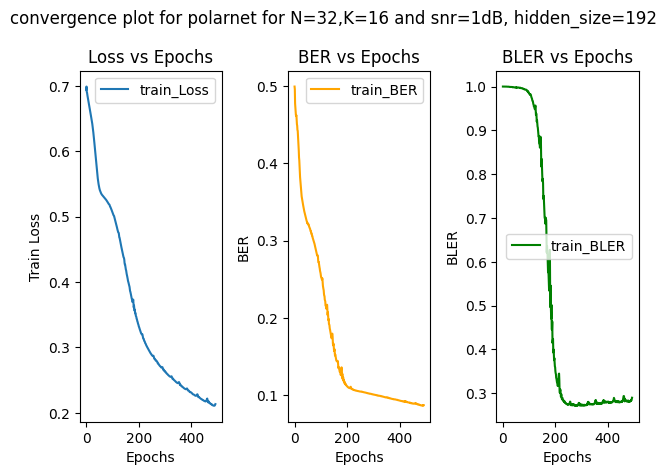

In [452]:
plt.suptitle('convergence plot for polarnet for N=32,K=16 and snr=1dB, hidden_size=192')
# Plot Loss vs Epochs
plt.subplot(1, 3, 1)
plt.plot(train_loss_values, label='train_Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()

# Plot BER vs Epochs
plt.subplot(1, 3, 2)
plt.plot(train_ber_values, label='train_BER', color='orange')
plt.title('BER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()

# Plot BLER vs Epochs

plt.subplot(1, 3, 3)
plt.plot(train_bler_values, label='train_BLER', color='green')
plt.title('BLER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BLER')
plt.legend()

plt.tight_layout()
plt.show()

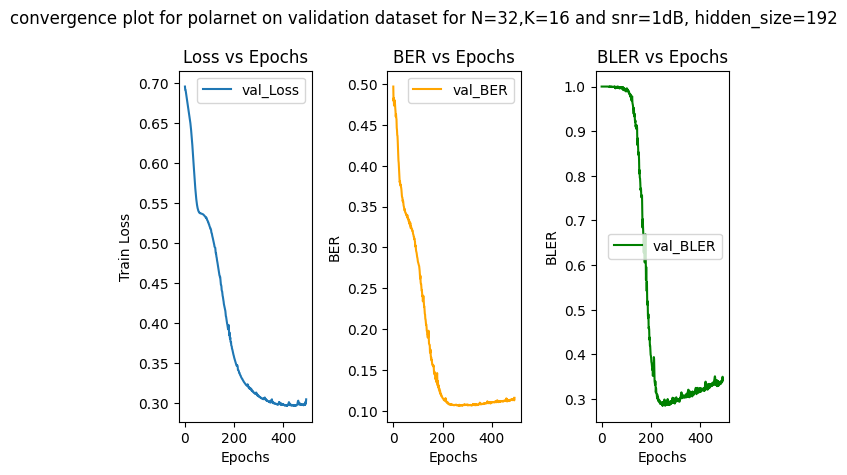

In [ ]:
plt.suptitle('convergence plot for polarnet on validation dataset for N=32,K=16 and snr=1dB, hidden_size=128')
# Plot Loss vs Epochs
plt.subplot(1, 3, 1)
plt.plot(val_loss_values, label='val_Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()

# Plot BER vs Epochs
plt.subplot(1, 3, 2)
plt.plot(val_ber_values, label='val_BER', color='orange')
plt.title('BER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()

# Plot BLER vs Epochs

plt.subplot(1, 3, 3)
plt.plot(val_bler_values, label='val_BLER', color='green')
plt.title('BLER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BLER')
plt.legend()

plt.tight_layout()
plt.show()

In [498]:
model.load_state_dict(torch.load(r'weights_rs\N_32_K_16_SNR_1_polarnet_nodropout_20k_hidden128_bn\epoch_280.pth'),strict=True)

<All keys matched successfully>

In [506]:
test_ber_total,test_bler_total = 0,0
count = 0
with torch.no_grad():
    model.eval()
    for batch_idx, test_batch in enumerate(test_dataloader):
        print(batch_idx)
        count += 1
        test_msg_bits = test_batch['msg_bits'].to(device)
        test_re_encoded_msg_bits = test_batch['re_encoded_msg_bits'].to(device)   

        test_final_predictions = model(test_re_encoded_msg_bits)
        test_predicted_bits = torch.round(torch.sigmoid(test_final_predictions))
        ber,bler = calculate_ber_bler(test_msg_bits,test_predicted_bits)
        test_ber_total += ber
        test_bler_total += bler
        
        # Print sequences for debugging (every 10th batch)
        if (batch_idx + 1) % 1 == 0:
            print(f"Test Batch {batch_idx + 1}")
            print(f"Predicted bits: {test_predicted_bits.int().tolist()}")
            print(f"Ground truth: {test_msg_bits.int().tolist()}")
            if torch.all(test_predicted_bits == test_msg_bits):
                print("Decoded correctly")
            else:
                print("Decoded incorrectly")
            print("----------")

test_avg_ber = test_ber_total / len(test_dataloader)
test_avg_bler =test_bler_total / len(test_dataloader)
print(f"Test Results - BER: {test_avg_ber:.4f}, BLER: {test_avg_bler:.4f}")

0
Test Batch 1
Predicted bits: [[1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1], [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0], [0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1], [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1], [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1], [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1], [1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1], [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1], [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1], [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0], [0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1], [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0], [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1], [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1], [1, 1, 0, 1, 0, 1,

In [421]:
i=8
test_msg_bits[i],(test_final_predictions[i]>=0).float()

(tensor([0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.],
        device='cuda:0'),
 tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.],
        device='cuda:0'))